In [2]:
pip install pandas

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

df = pd.read_csv("./dataset/heart_clean.csv")

x = df.drop("target", axis=1)
y = df["target"]

print("Dataset shape:", df.shape)


Dataset shape: (303, 14)


In [2]:
from sklearn.model_selection import train_test_split

# 80-20 Split
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", x_train.shape)
print("Test size:", x_test.shape)

Train size: (242, 13)
Test size: (61, 13)


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [4]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42
)

lr_model.fit(x_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [5]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y_pred = lr_model.predict(x_test_scaled)
y_prob = lr_model.predict_proba(x_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Logistic Regression Performance:")
print("Accuracy :", round(accuracy, 4))
print("F1-score :", round(f1, 4))
print("ROC-AUC  :", round(roc_auc, 4))


Logistic Regression Performance:
Accuracy : 0.8689
F1-score : 0.8667
ROC-AUC  : 0.9535


In [13]:
# pip install shap

import shap
import numpy as np

def model_predict(X):
    return lr_model.predict_proba(X)[:, 1]

background = shap.sample(x_train_scaled, 50, random_state=42)

In [14]:
explainer = shap.KernelExplainer(
    model_predict,
    background
)

shap_values = explainer.shap_values(x_test_scaled)


100%|██████████| 61/61 [00:04<00:00, 14.84it/s]


In [15]:
type(shap_values), np.array(shap_values).shape


(numpy.ndarray, (61, 13))

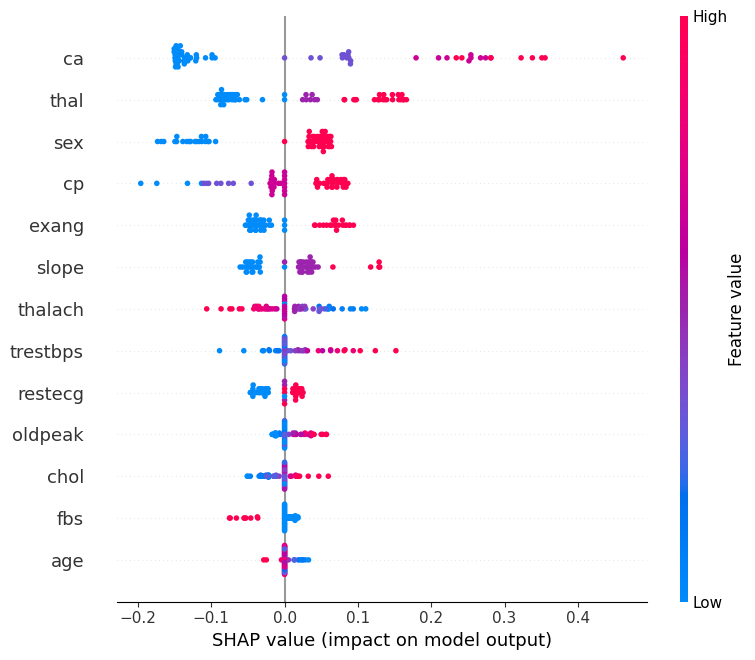

In [16]:

shap.summary_plot(
    shap_values,
    x_test,
    feature_names=x.columns
)


In [17]:
# Mean absolute SHAP value per feature
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

feature_importance = pd.DataFrame({
    "feature": x.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False)

feature_importance


,feature,mean_abs_shap
11,ca,0.163206
12,thal,0.088952
1,sex,0.074529
2,cp,0.054862
8,exang,0.046295
10,slope,0.042123
7,thalach,0.036870
3,trestbps,0.023443
6,restecg,0.023003
9,oldpeak,0.014588


In [18]:
feature_importance.to_csv(
    "./results/lr_shap_baseline_feature_importance.csv",
    index=False
)


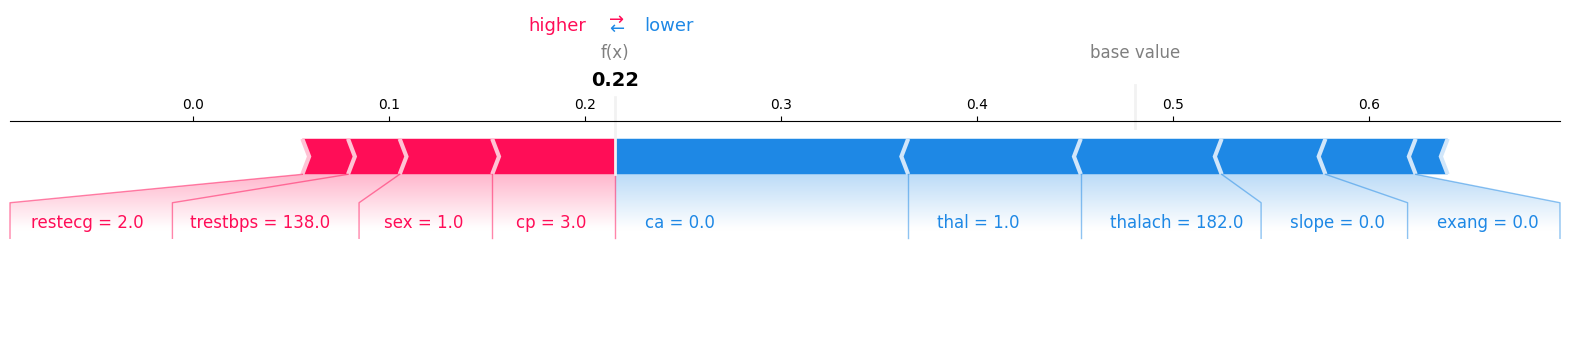

In [19]:
idx = 0  # first test sample

shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    x_test.iloc[idx],
    matplotlib=True
)
